# Basic linear regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import unittest
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from IPython.display import clear_output

from functions import fillna_by_time, Check_fillna_by_time
unittest.main(argv=["", "Check_fillna_by_time"], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


## Data processing

In [2]:
building_info = pd.read_csv('.\data\\building_metadata.csv')
train_meters = pd.read_csv('.\data\\train.csv')
weather_train = pd.read_csv('.\data\\weather_train.csv')

In [3]:
building_info.head(3)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


In [4]:
# separate tasks
electricity = train_meters[train_meters.meter==0].drop('meter', axis=1)
chilledwater = train_meters[train_meters.meter==1].drop('meter', axis=1)
steam = train_meters[train_meters.meter==2].drop('meter', axis=1)
hotwater = train_meters[train_meters.meter==3].drop('meter', axis=1)

del train_meters

In [5]:
# let's start with electricity
# we should join dataframes to see the whole picture
electricity = electricity.set_index('building_id').join(
    building_info.set_index('building_id'), 
    on='building_id')
electricity.set_index(pd.Index([i for i in range(len(electricity))]), inplace=True)

In [6]:
# remove nans
electricity['floor_count'].fillna(electricity['floor_count'].median(), inplace=True)
electricity['year_built'].fillna(electricity['year_built'].median(), inplace=True)

In [7]:
for i in electricity.columns:
    part = 'has Nans!!!' if electricity[i].isna().any() else 'doesn\'t have Nans'
    print(f'column {i} {part}')

column timestamp doesn't have Nans
column meter_reading doesn't have Nans
column site_id doesn't have Nans
column primary_use doesn't have Nans
column square_feet doesn't have Nans
column year_built doesn't have Nans
column floor_count doesn't have Nans


In [8]:
print('There are', len(weather_train['site_id'].unique()), 'unique site_ids')

mean_for_site_id = 0
for i in weather_train['site_id'].unique():
    mean_for_site_id += weather_train['site_id'][weather_train['site_id'] == i].count()
mean_for_site_id /= len(weather_train['site_id'].unique())

print('But for every site_id there are in average', int(mean_for_site_id), 'rows')
print('We are going to have', int(mean_for_site_id)*len(electricity),'raws at all!!!')

There are 16 unique site_ids
But for every site_id there are in average 8735 rows
We are going to have 105352048850 raws at all!!!


In [9]:
for index in weather_train['site_id'].unique():
    testing_site_id = weather_train[weather_train['site_id'] == index]
    
    with_nans = testing_site_id['air_temperature'].isna()
    for i in testing_site_id.columns:
        with_nans |= testing_site_id[i].isna()

    print('for', index, len(testing_site_id[~with_nans])/len(testing_site_id), 
          'of data doesn\'t have Nans at all')

for 0 0.5429189435336976 of data doesn't have Nans at all
for 1 0.0 of data doesn't have Nans at all
for 2 0.6747125128088353 of data doesn't have Nans at all
for 3 0.5714123006833713 of data doesn't have Nans at all
for 4 0.4361835363770921 of data doesn't have Nans at all
for 5 0.0 of data doesn't have Nans at all
for 6 0.5867683898884081 of data doesn't have Nans at all
for 7 0.0 of data doesn't have Nans at all
for 8 0.5429189435336976 of data doesn't have Nans at all
for 9 0.44123006833712985 of data doesn't have Nans at all
for 10 0.666021407424277 of data doesn't have Nans at all
for 11 0.0 of data doesn't have Nans at all
for 12 0.0 of data doesn't have Nans at all
for 13 0.49379483092337473 of data doesn't have Nans at all
for 14 0.5924575595305913 of data doesn't have Nans at all
for 15 0.006505796072864916 of data doesn't have Nans at all


In [10]:
# research features for each site_id == 0
# drop time and site_id because they are not useful now
# (time just shows us the order to sort)
testing_site_id = weather_train[weather_train['site_id'] == 0].drop('site_id', axis=1)
for i in testing_site_id.columns[1:]:
    testing_site_id = fillna_by_time(testing_site_id, i)
testing_site_id = testing_site_id.drop('timestamp', axis=1)

testing_site_id.head(3)

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
1,24.4,6.0,21.1,-1.0,1020.2,70.0,1.5
2,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


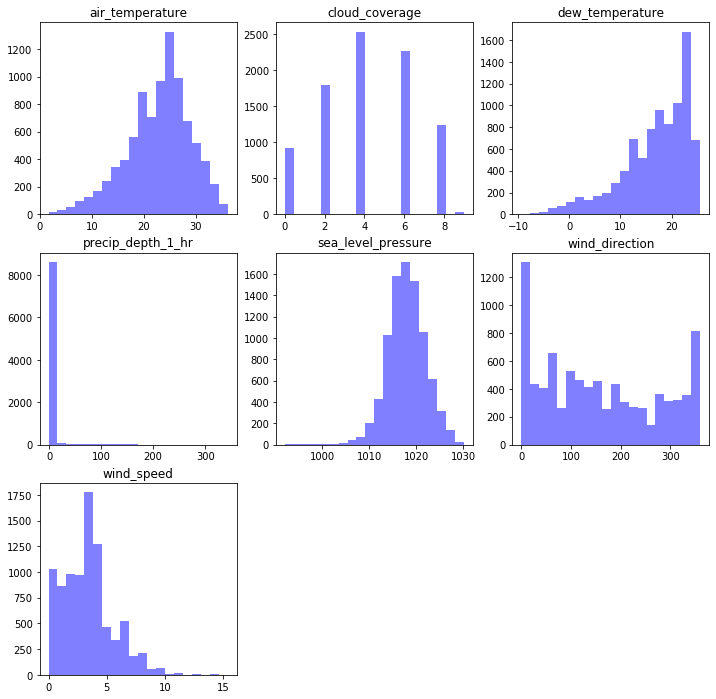

In [11]:
num_bins = 20
plt.figure(figsize=(12, 12))

index = 1
for i in testing_site_id.columns:
    plt.subplot((len(testing_site_id.columns)+2)//3, 3, index)
    plt.title(i)
    n, bins, patches = plt.hist(testing_site_id[i], num_bins, facecolor='blue', alpha=0.5)
    index += 1

plt.show()

In [12]:
# precip_depth_1_hr now doesn't have any useful info
testing_site_id = testing_site_id.drop('precip_depth_1_hr', axis=1)

In [14]:
# let's fit normal distribution on our data
num_bins = 20


def get_in_columns(column, testing_site_id):
    y, x, patches = plt.hist(testing_site_id[column], num_bins, facecolor='blue', alpha=0.5)
    x = np.array(x[:-1], dtype='float32')
    y = np.array(y, dtype='float32')

    x = ((x - x.mean())/x.max())*10
    y /= y.max()
    
    return x, y


x, y = get_in_columns('air_temperature', testing_site_id)

In [11]:
class DestributionLayer(layers.Layer):
    def __init__(self, mu=0., st=1.):
        super(DestributionLayer, self).__init__()
        
        self.mu_var = mu
        self.st_var = st
        
        self.trainable = True
        
        
    def build(self, input_shape):
        self.mu = self.add_weight(shape=(input_shape[-1]),
                             initializer=tf.keras.initializers.Constant(self.mu_var),
                             trainable=True)
        
        self.st = self.add_weight(shape=(input_shape[-1]),
                             initializer=tf.keras.initializers.Constant(self.st_var),
                             trainable=True)
        
    def call(self, inputs):
        return tf.math.exp(-(inputs - self.mu)**2 / (2*self.st)) / tf.math.sqrt(2*np.pi*self.st)
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [12]:
num_layers = 5


def loss(y, y_pred):
    return tf.reduce_mean((y_pred-y)**2)


def maxis(y):
    return tf.reduce_max(y)
  
    
def distribution_model(num_layers):
    inputs_ = layers.Input((1,))
    sp = []
    for i in range(5):
        sp.append(DestributionLayer((np.random.rand(1)*2-1)*2, 0.5)(inputs_))
    predictions = sum(sp)

    model_ = tf.keras.Model(
            inputs=inputs_, 
            outputs=predictions)

    model_.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
                  loss=loss)
    
    return model_


model = distribution_model(num_layers)
model.fit(x, y, batch_size=len(x), epochs=800)
plt.plot(x, model(x))
plt.plot(x, y)
plt.show()

'\nmodel = distribution_model(num_layers)\nmodel.fit(x, y, batch_size=len(x), epochs=1)\nplt.plot(x, model(x))\nplt.plot(x, y)\nplt.show()\n'

### There is a long-run calculation, skip it if you have weather_train_ditributions.csv file

Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.1566
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.5082
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.3528
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.6067
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.4706
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.6634
Train on 20 samples
20/20 [==============================] - 1s 44ms/sample - loss: 0.0931
Train on 20 samples
20/20 [==============================] - 0s 24ms/sample - loss: 0.5882
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.1222
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.2773
Train on 20 samples
20/20 [==============================] - 1s 45ms/sample - loss: 0.3191

20/20 [==============================] - 1s 50ms/sample - loss: 0.2756
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.5058
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.3988
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 1.3026
Train on 20 samples
20/20 [==============================] - 1s 26ms/sample - loss: 0.5812
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.4827


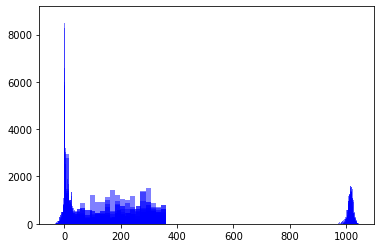

In [35]:
# we have a distribution layer and model with several of them
# so, we can simulate any distribution for any column for any site_id

columns_list = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed']
weather_distrib = pd.DataFrame(columns = ['site_id']+[i + '_' + j for i in columns_list 
                                    for j in list(itertools.chain(*[['mu' + str(i), 'st' + str(i)]
                                                                for i in range(num_layers)]))]).set_index('site_id')
for testing_site_index in weather_train['site_id'].unique():  
    
    testing_site_id = weather_train[weather_train['site_id'] == testing_site_index].drop('site_id', axis=1)
    testing_site_id = testing_site_id.drop('timestamp', axis=1)
    testing_site_id = testing_site_id.drop('precip_depth_1_hr', axis=1)
    
    for i in testing_site_id.columns:
        try:
            testing_site_id = fillna_by_time(testing_site_id, i)
        except AssertionError:
            testing_site_id[i].fillna(0, inplace=True)
            testing_site_id = fillna_by_time(testing_site_id, i)
    
    data_per_site_id = []
    for i in testing_site_id.columns:
        temp = []
        model = distribution_model(num_layers)
        x, y = get_in_columns(i, testing_site_id)
        model.fit(x, y, batch_size=len(x), epochs=800)

        for j in model.weights:
            temp.append(j.numpy()[0])

        temp = [[temp[i*2], temp[i*2+1]] for i in range(num_layers)]
        temp.sort()
        data_per_site_id.append(list(itertools.chain(*temp)))

    weather_distrib.loc[testing_site_index] = [data_per_site_id[i][j] 
                                         for i in range(len(testing_site_id.columns)) 
                                         for j in range(num_layers*2)]

In [38]:
weather_distrib.to_csv('.\data\\weather_train_ditributions.csv') 

## Regression model

In [42]:
weather_distrib = pd.read_csv('.\data\\weather_train_ditributions.csv').set_index('site_id')

In [44]:
electricity = electricity.set_index('site_id').join(
    weather_distrib, on='site_id')

In [46]:
electricity.head(3)

,timestamp,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature_mu0,air_temperature_st0,air_temperature_mu1,air_temperature_st1,...,wind_speed_mu0,wind_speed_st0,wind_speed_mu1,wind_speed_st1,wind_speed_mu2,wind_speed_st2,wind_speed_mu3,wind_speed_st3,wind_speed_mu4,wind_speed_st4
site_id,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:00:00,0.0,Education,7432,2008.0,3.0,-1.225079,0.531623,-0.635134,0.531623,...,-1.477082,0.531623,-1.149131,0.531623,-1.104344,0.531623,-0.41849,0.531623,0.185063,0.531622
0,2016-01-01 00:00:00,0.0,Education,2720,2004.0,3.0,-1.225079,0.531623,-0.635134,0.531623,...,-1.477082,0.531623,-1.149131,0.531623,-1.104344,0.531623,-0.41849,0.531623,0.185063,0.531622
0,2016-01-01 00:00:00,0.0,Education,5376,1991.0,3.0,-1.225079,0.531623,-0.635134,0.531623,...,-1.477082,0.531623,-1.149131,0.531623,-1.104344,0.531623,-0.41849,0.531623,0.185063,0.531622


In [53]:
columns_to_oh = ['primary_use', 'year_built']
for col in columns_to_oh:
    one_hot = pd.get_dummies(electricity[col])
    one_hot.columns = [f'{col}_one_hot_{str(val)}' for val in one_hot.columns]
    electricity = pd.concat([electricity, one_hot], axis=1)

In [ ]:
electricity[:3].drop('primary_use', axis=1).head(3)

In [ ]:
3